# Compare GPs + Plot

In [1]:
import fastgps
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot
import tueplots.figsizes

In [2]:
torch.set_default_dtype(torch.float64)
device = "cpu"

In [3]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
_alpha = 0.25
WIDTH = 2*(500/72)
LINEWIDTH = 3
MARKERSIZE = 100

## True Function

In [4]:
d = 1
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768):
    # https://www.sfu.ca/~ssurjano/ackley.html
    assert x.ndim==2
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y
fs = [lambda x: f_ackley(x,c=0), lambda x: f_ackley(x)]
num_tasks = len(fs)
n = torch.tensor([2**4,2**3])

## Parameters

In [5]:
seqs_std = [qp.DigitalNetB2(1,seed=11,randomize="DS"),qp.DigitalNetB2(1,seed=13,randomize="DS")]
seqs_lattice = [qp.Lattice(1,seed=7),qp.Lattice(1,seed=2)]
seqs_dnb2s = [qp.DigitalNetB2(1,seed=7,randomize="DS"),qp.DigitalNetB2(1,seed=2,randomize="DS")]

seqs_list = [seqs_std,seqs_lattice,seqs_dnb2s]
FGPClasses = [fastgps.StandardGP,fastgps.FastGPLattice,fastgps.FastGPDigitalNetB2]
ngptypes = len(FGPClasses)

xticks = torch.linspace(0,1,1001,device=device)[1:-1,None]
yticks = torch.vstack([fs[i](xticks) for i in range(num_tasks)])

## Independent Single Task GPs

In [6]:
pmeans = [torch.empty((num_tasks,len(xticks))) for i in range(ngptypes)]
ci_lows = [torch.empty((num_tasks,len(xticks))) for i in range(ngptypes)]
ci_highs = [torch.empty((num_tasks,len(xticks))) for i in range(ngptypes)]
fgp_indep = [[FGPClass(seqs=seqs[l],device=device) for l in range(num_tasks)] for FGPClass,seqs in zip(FGPClasses,seqs_list)]
for i in range(ngptypes):
    print(type(fgp_indep[i][0]).__name__)
    for l in range(num_tasks):
        x_next = fgp_indep[i][l].get_x_next(n=n[l].item())
        y_next = torch.vstack([fs[i](x_next) for i in range(num_tasks)])
        fgp_indep[i][l].add_y_next(y_next[l])
        fgp_indep[i][l].fit()
        pmeans[i][l],_,_,ci_lows[i][l],ci_highs[i][l] = fgp_indep[i][l].post_ci(xticks)

StandardGP


     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.19e+06   | 2.37e+06   | -1.18e+02 
            5.00e+00 | 8.39e+05   | 1.68e+06   | -1.09e+02 
            1.00e+01 | 2.98e+05   | 5.96e+05   | -6.94e+01 
            1.50e+01 | 6.32e+01   | 7.23e+00   | 8.97e+01  
            2.00e+01 | 5.80e+01   | 1.11e+01   | 7.56e+01  
            2.50e+01 | 5.74e+01   | 2.18e+01   | 6.37e+01  
            3.00e+01 | 5.67e+01   | 1.61e+01   | 6.80e+01  
            3.20e+01 | 5.67e+01   | 1.58e+01   | 6.82e+01  
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 8.98e+05   | 1.80e+06   | -4.71e+01 
            5.00e+00 | 6.59e+05   | 1.32e+06   | -3.94e+01 
            1.00e+01 | 7.29e+04   | 1.46e+05   | -5.27e+00 
            1.50e+01 | 3.22e+01   | 5.28e+00   | 4.44e+01  
            2.00e+01 | 3.20e+01   | 7.80

## Multi-Task Fast GPs

In [7]:
fgp_multitask = [FGPClass(seqs=seqs,num_tasks=num_tasks,device=device) for FGPClass,seqs in zip(FGPClasses,seqs_list)]
pmean_mt = [None for i in range(ngptypes)]
ci_low_mt = [None for i in range(ngptypes)]
ci_high_mt = [None for i in range(ngptypes)]
for i in range(ngptypes):
    print(type(fgp_multitask[i]).__name__)
    x_next = fgp_multitask[i].get_x_next(n=n)
    y_next = [fs[i](x_next[i]) for i in range(num_tasks)]
    fgp_multitask[i].add_y_next(y_next)
    fgp_multitask[i].fit()
    pmean_mt[i],_,_,ci_low_mt[i],ci_high_mt[i] = fgp_multitask[i].post_ci(xticks)

StandardGP
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.45e+06   | 2.90e+06   | -1.52e+02 


            5.00e+00 | 3.85e+05   | 7.70e+05   | -1.14e+02 
            1.00e+01 | 1.40e+04   | 2.80e+04   | 1.61e+00  
            1.50e+01 | 1.38e+02   | 7.13e+01   | 1.60e+02  
            2.00e+01 | 1.06e+02   | 1.63e+01   | 1.52e+02  
            2.50e+01 | 9.97e+01   | 1.36e+01   | 1.42e+02  
            3.00e+01 | 9.11e+01   | 2.84e+01   | 1.10e+02  
            3.50e+01 | 7.94e+01   | 1.35e+01   | 1.01e+02  
            4.00e+01 | 7.04e+01   | 2.73e+01   | 6.94e+01  
            4.50e+01 | 7.03e+01   | 2.56e+01   | 7.08e+01  
            5.00e+01 | 7.02e+01   | 2.46e+01   | 7.17e+01  
            5.10e+01 | 7.02e+01   | 2.42e+01   | 7.21e+01  
FastGPLattice
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 4.19e+02   | 8.13e+02   | -1.83e+01 
            5.00e+00 | 8.48e+01   | 8.80e+01   | 3.75e+01  
            1.00e+01 | 6.65e+01   | 2.52e+01   | 6.37e+01  
            1.50e+01 | 5.7

            2.00e+01 | 7.03e+01   | 2.36e+01   | 7.29e+01  


            2.50e+01 | 6.95e+01   | 2.43e+01   | 7.06e+01  
            3.00e+01 | 6.90e+01   | 2.63e+01   | 6.77e+01  
            3.50e+01 | 6.90e+01   | 2.52e+01   | 6.86e+01  
            4.00e+01 | 6.90e+01   | 2.40e+01   | 6.98e+01  
            4.10e+01 | 6.90e+01   | 2.40e+01   | 6.98e+01  


## Plot

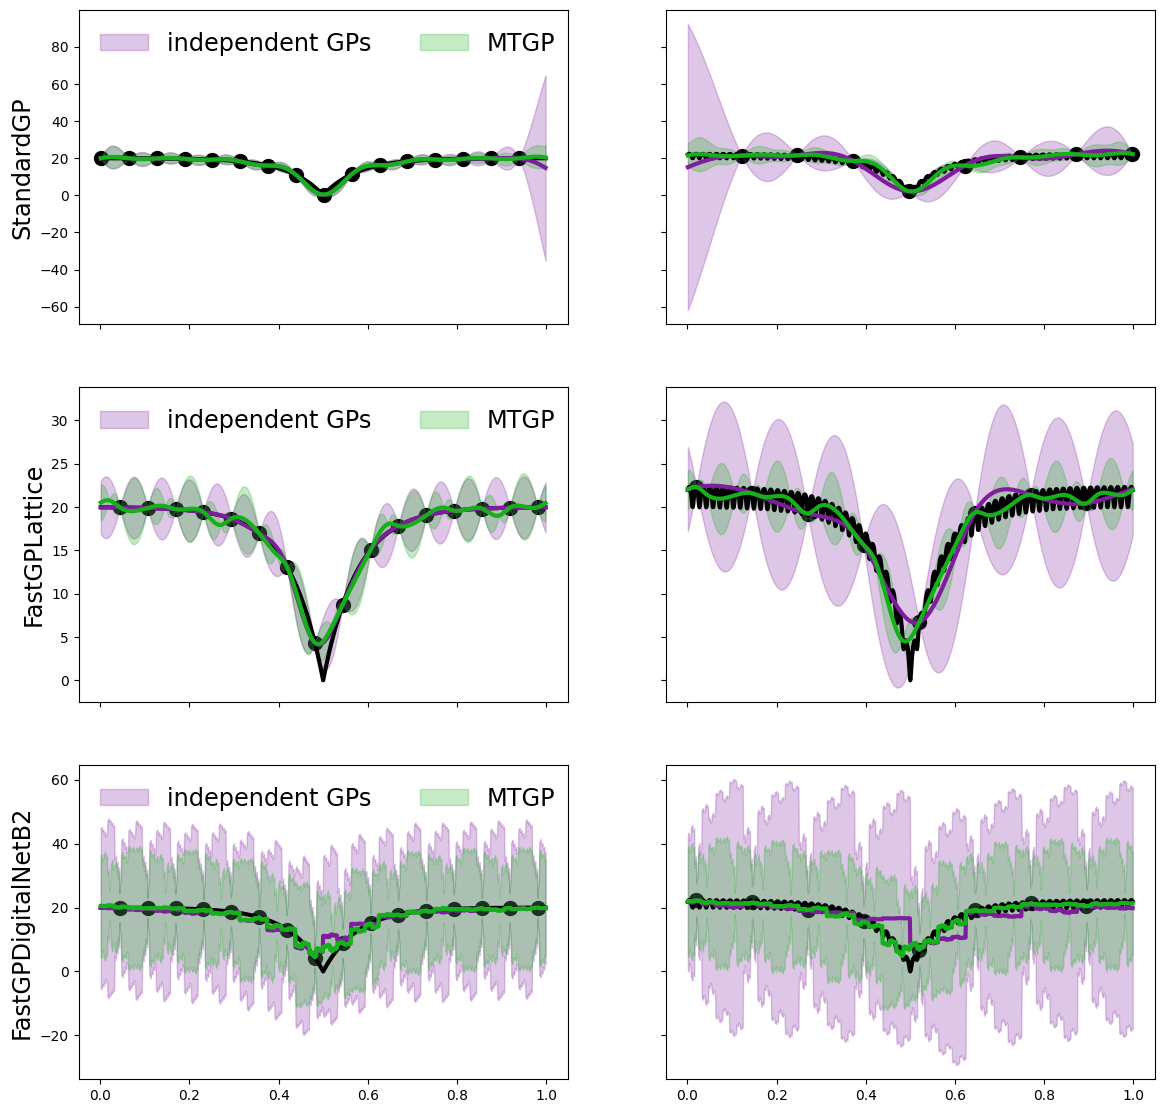

In [8]:
fig,ax = pyplot.subplots(nrows=ngptypes,ncols=num_tasks,figsize=(WIDTH,WIDTH/num_tasks*ngptypes/1.5),sharex=True,sharey="row")
ax = ax.reshape((ngptypes,num_tasks))
for i in range(ngptypes):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),yticks[l].cpu(),color="k",linewidth=LINEWIDTH)
        ax[i,l].scatter(fgp_indep[i][l].x[:,0].cpu(),fgp_indep[i][l].y.cpu(),color="k",s=MARKERSIZE)
    pltmin = min([ci_lows[i][l].min() for l in range(num_tasks)]+[ci_low_mt[i].min()])
    pltmax = max([ci_highs[i][l].max() for l in range(num_tasks)]+[ci_high_mt[i].max()])
    ax[i,0].set_ylim([pltmin-.05*(pltmax-pltmin),pltmax+.05*(pltmax-pltmin)])
    ax[i,0].set_ylabel(type(fgp_multitask[i]).__name__,fontsize="xx-large")
fig.savefig("./mtgps0.pdf",bbox_inches="tight")
for i in range(ngptypes):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),pmeans[i][l].cpu(),color=colors[0],linewidth=LINEWIDTH)
        ax[i,l].fill_between(xticks[:,0].cpu(),ci_lows[i][l].cpu(),ci_highs[i][l].cpu(),color=colors[0],alpha=_alpha,label="independent GPs")
    ax[i,0].legend(frameon=False,loc="upper left",ncols=2,fontsize="xx-large") 
fig.savefig("./mtgps1.pdf",bbox_inches="tight")
for i in range(ngptypes):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),pmean_mt[i][l].cpu(),color=colors[1],linewidth=LINEWIDTH)
        ax[i,l].fill_between(xticks[:,0].cpu(),ci_low_mt[i][l].cpu(),ci_high_mt[i][l].cpu(),color=colors[1],alpha=_alpha,label="MTGP")
    ax[i,0].legend(frameon=False,loc="upper left",ncols=2,fontsize="xx-large") 
fig.savefig("./mtgps2.pdf",bbox_inches="tight")